### Introduction

UMAP is a method that can allow the spatial recognition of a relationship between the input data and the associated labels. It reduced the dimensions of the data into 2D and clusters them based on similarity.

We start off by importing some modules.

In [1]:
import sys
sys.path.append('../..')  # Adjust the path as necessary to import from the parent directory

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For feature selection
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.feature_selection import SelectKBest, f_classif

# For dimensionality reduction
import umap.umap_ as umap

# For optional scaling
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore') # Suppress common warnings for cleaner output

c:\Users\Owner\Documents\GitHub\epigenetic-memory-loss-methylation\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Data

In [2]:
from model.data.loaders.loader_xgboost import load_data_h5

# Load the data
dir_h5 = '../data/train/methylation.h5'
dir_ids = '../data/train/idmap.csv'
X, y = load_data_h5(dir_h5, dir_ids, indices=None)
print(f"Data shape: {X.shape}, Labels shape: {y.shape}")

Data shape: (1026, 893944), Labels shape: (1026,)


### Pre-processing Method \#1

In [3]:
features = np.zeros(X.shape[1])
print(f"Number of features before selection: {len(features)}")
# First, handle NaNs if any exist. A simple imputation is to use the mean.
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Step 2: Feature Selection using ANOVA F-test
print("Performing ANOVA F-test on all features...")
f_values, p_values = f_classif(X_imputed, y)

# Apply Multiple Testing Correction (Benjamini-Hochberg FDR)
print("Applying multiple testing correction...")
rejected, corrected_p_values, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

print(f"Number of significant features after FDR correction: {np.sum(rejected)}")

# If too many features remain, take top N most significant
k = 10000  # Target number of features
if np.sum(rejected) > k:
    print(f"Selecting top {k} most significant features...")
    top_k_indices = np.argsort(corrected_p_values)[:k]
else:
    print(f"Using all {np.sum(rejected)} significant features...")
    top_k_indices = np.where(rejected)[0]

# Create reduced feature matrix
X_reduced = X_imputed[:, top_k_indices]
print(f"Reduced data shape: {X_reduced.shape}")

Number of features before selection: 893944
Performing ANOVA F-test on all features...
Applying multiple testing correction...
Number of significant features after FDR correction: 368221
Selecting top 10000 most significant features...
Reduced data shape: (1026, 10000)


### Pre-processing Method \#2

In [ ]:
variance = { i: np.var(X[:, i]) for i in range(X.shape[1]) }
variance = { i: v for i, v in variance.items() if not np.isnan(v) }
top_k_items = { i: v for i, v in sorted(variance.items(), key=lambda item: item[1], reverse=True)[:k] }
X_reduced = X[:, list(top_k_items.keys())]

Standardizing features...
Running UMAP...
UMAP embedding shape: (1026, 2)
Creating visualization...


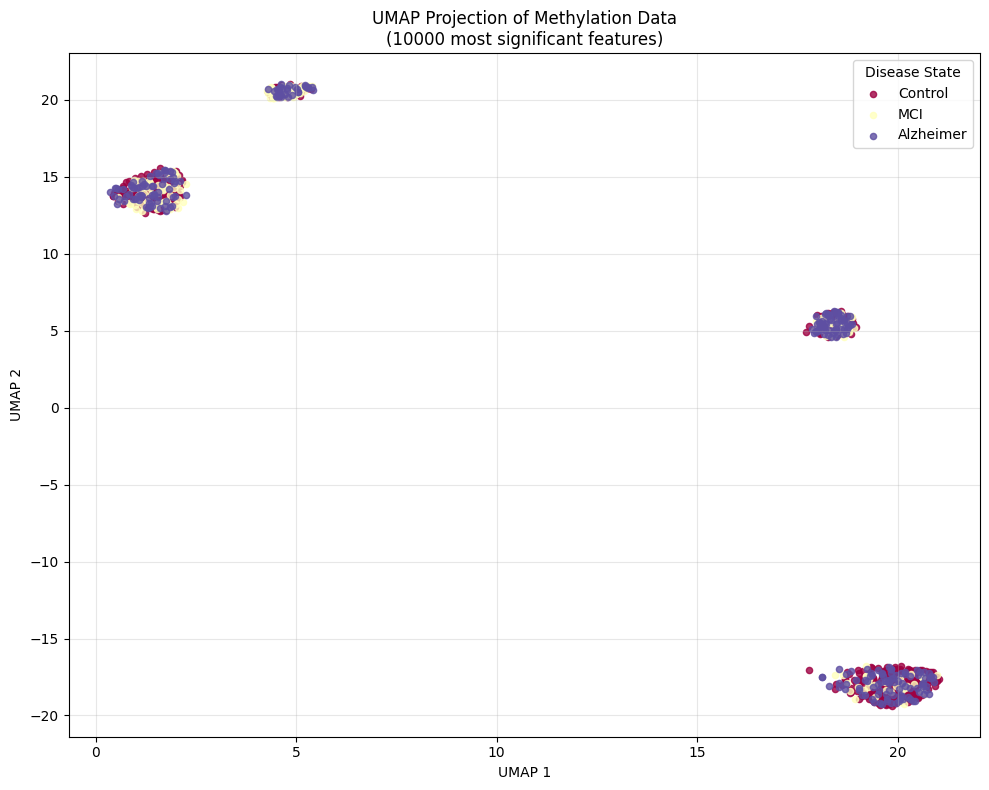

Saving selected feature indices...
Analysis complete!


In [22]:
# Step 3: Standardize the data
print("Standardizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)

# Step 4: Run UMAP
print("Running UMAP...")
reducer = umap.UMAP(
    n_neighbors=15,    # Number of neighbors to consider
    min_dist=0.1,      # Minimum distance between points in embedding
    random_state=42    # For reproducible results
)
embedding = reducer.fit_transform(X_scaled)
print(f"UMAP embedding shape: {embedding.shape}")

# Step 5: Visualize
print("Creating visualization...")
plt.figure(figsize=(10, 8))

# Create a color map for the labels
unique_labels = np.unique(y)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
label_names = ['Control', 'MCI', 'Alzheimer']  # More meaningful names

for i, label in enumerate(unique_labels):
    mask = (y == label)
    plt.scatter(embedding[mask, 0], 
                embedding[mask, 1], 
                c=[colors[i]], 
                label=label_names[i] if i < len(label_names) else f'Class {label}', 
                s=20, 
                alpha=0.8)

plt.title(f'UMAP Projection of Methylation Data\n({k} most significant features)')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Disease State')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: Save the indices of selected features for downstream analysis
print("Saving selected feature indices...")
np.save('selected_feature_indices.npy', top_k_indices)
np.save('umap_embedding.npy', embedding)
print("Analysis complete!")